# 数据操作/数据变换

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/dataset/mindspore_eager.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/dataset/mindspore_eager.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/dataset/eager.ipynb)


## 数据操作

`mindspore.dataset` 提供了一系列的数据集操作，用户通过这些数据集操作，如 [.shuffle](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/dataset_method/operation/mindspore.dataset.Dataset.shuffle.html#mindspore.dataset.Dataset.shuffle) / [.filter](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/dataset_method/operation/mindspore.dataset.Dataset.filter.html#mindspore.dataset.Dataset.filter) / [.skip](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/dataset_method/operation/mindspore.dataset.Dataset.skip.html#mindspore.dataset.Dataset.skip) / [.take](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/dataset_method/operation/mindspore.dataset.Dataset.take.html#mindspore.dataset.Dataset.take) / [.batch](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/dataset_method/batch/mindspore.dataset.Dataset.batch.html#mindspore.dataset.Dataset.batch) / … 来实现数据集的进一步混洗、过滤、跳过、批处理组合等功能。

常用数据变换操作包括：

- `.filter(...)`：通过指定条件，多数据进行过滤，保留满足预期条件的样本。
- `.project(...)`：对多个数据列进行排序，或删除不需要的数据列。
- `.rename(...)`： 对指定数据列进行重命名，便于标记数据特性。
- `.shuffle(...)`： 划分一个数据缓冲区，对落入缓冲区的数据进行混洗。
- `.skip(...)`： 跳过数据集的前n条样本。
- `.take(...)`： 只获取数据集的前n条样本。
- `.map(...)`：数据变换，通过自定义方法对每个样本进行变换增强。
- `.batch(...)`：对 `batch_size` 条数据进行组合。

下面将通过示例代码展示filter、skip、batch数据操作。

In [1]:
from mindspore.dataset import GeneratorDataset

# Random-accessible object as input source
class MyDataset:
    def __init__(self):
        self._data = [1, 2, 3, 4, 5, 6]
    def __getitem__(self, index):
        return self._data[index]
    def __len__(self):
        return len(self._data)

loader = MyDataset()

# find sampler which value < 4
dataset = GeneratorDataset(source=loader, column_names=["data"], shuffle=False)
filtered_dataset = dataset.filter(lambda x: x < 4, input_columns=["data"])
print("filtered_dataset", list(filtered_dataset))

# skip dirst 3 samples
dataset = GeneratorDataset(source=loader, column_names=["data"], shuffle=False)
skipped_dataset = dataset.skip(3)
print("skipped_dataset", list(skipped_dataset))

# batch the dataset by batch_size=2
dataset = GeneratorDataset(source=loader, column_names=["data"], shuffle=False)
batched_dataset = dataset.batch(2, num_parallel_workers=1)
print("batched_dataset", list(batched_dataset))

filtered_dataset [[Tensor(shape=[], dtype=Int64, value= 1)], [Tensor(shape=[], dtype=Int64, value= 2)], [Tensor(shape=[], dtype=Int64, value= 3)]]
skipped_dataset [[Tensor(shape=[], dtype=Int64, value= 4)], [Tensor(shape=[], dtype=Int64, value= 5)], [Tensor(shape=[], dtype=Int64, value= 6)]]
batched_dataset [[Tensor(shape=[2], dtype=Int64, value= [1, 2])], [Tensor(shape=[2], dtype=Int64, value= [3, 4])], [Tensor(shape=[2], dtype=Int64, value= [5, 6])]]


除此之外，还有数据集组合、切分、保存等操作。

### 数据集组合

数据集组合可以将多个数据集以串联/并朕的方式组合起来，形成一个全新的dataset对象。

In [2]:
import mindspore.dataset as ds

ds.config.set_seed(1234)

# concat same column of two datasets
data = [1, 2, 3]
dataset1 = ds.NumpySlicesDataset(data=data, column_names=["column_1"])

data = [4, 5, 6]
dataset2 = ds.NumpySlicesDataset(data=data, column_names=["column_1"])

dataset = dataset1.concat(dataset2)
for item in dataset.create_dict_iterator():
    print("concated dataset", item)


# zip different columns of two datasets
data = [1, 2, 3]
dataset1 = ds.NumpySlicesDataset(data=data, column_names=["column_1"])

data = [4, 5, 6]
dataset2 = ds.NumpySlicesDataset(data=data, column_names=["column_2"])

dataset = dataset1.zip(dataset2)
for item in dataset.create_dict_iterator():
    print("zipped dataset", item)

concated dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 2)}
concated dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 3)}
concated dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 1)}
concated dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 5)}
concated dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 6)}
concated dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 4)}
zipped dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 2), 'column_2': Tensor(shape=[], dtype=Int64, value= 5)}
zipped dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 3), 'column_2': Tensor(shape=[], dtype=Int64, value= 6)}
zipped dataset {'column_1': Tensor(shape=[], dtype=Int64, value= 1), 'column_2': Tensor(shape=[], dtype=Int64, value= 4)}


### 数据集切分

将数据集切分成训练数据集和验证数据集，分别用于训练过程和验证过程。

In [3]:
import mindspore.dataset as ds

data = [1, 2, 3, 4, 5, 6]
dataset = ds.NumpySlicesDataset(data=data, column_names=["column_1"], shuffle=False)

train_dataset, eval_dataset = dataset.split([4, 2])

print(">>>> train dataset >>>>")
for item in train_dataset.create_dict_iterator():
    print(item)

print(">>>> eval dataset >>>>")
for item in eval_dataset.create_dict_iterator():
    print(item)

>>>> train dataset >>>>
{'column_1': Tensor(shape=[], dtype=Int64, value= 6)}
{'column_1': Tensor(shape=[], dtype=Int64, value= 4)}
{'column_1': Tensor(shape=[], dtype=Int64, value= 1)}
{'column_1': Tensor(shape=[], dtype=Int64, value= 5)}
>>>> eval dataset >>>>
{'column_1': Tensor(shape=[], dtype=Int64, value= 3)}
{'column_1': Tensor(shape=[], dtype=Int64, value= 2)}


### 数据集保存

将数据集重新保存到MindRecord数据格式。

In [4]:
import os
import mindspore.dataset as ds

ds.config.set_seed(1234)

data = [1, 2, 3, 4, 5, 6]
dataset = ds.NumpySlicesDataset(data=data, column_names=["column_1"])

if os.path.exists("./train_dataset.mindrecord"):
    os.remove("./train_dataset.mindrecord")
if os.path.exists("./train_dataset.mindrecord.db"):
    os.remove("./train_dataset.mindrecord.db")

dataset.save("./train_dataset.mindrecord")

## 数据变换

通常情况下，直接加载的原始数据并不能直接送入神经网络进行训练，此时我们需要对其进行数据预处理。
MindSpore提供不同种类的数据变换（Transforms），配合数据处理Pipeline来实现数据预处理。

这些变换通常有2种使用方法，分别为“基于数据操作map进行数据变换”与“轻量化数据变换”，下面分别进行介绍。

### 基于`map`数据操作进行数据变换

- `mindspore.dataset` 提供了面向图像、文本、音频等不同数据类型的内置数据变换操作，所有的变换均可传到的 `map` 操作中，通过 `map` 方法自动对每条样本进行变换。
- 除了内置的数据变换外，`map` 操作也可以执行用户自定义的变换操作。


In [5]:
# Download data from open datasets
from download import download
from mindspore.dataset import MnistDataset
import mindspore.dataset.vision as vision

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)

# create MNIST loader
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)

# resize samples to (64, 64) using built-in transformation
train_dataset = train_dataset.map(operations=[vision.Resize((64, 64))],
                                  input_columns=['image'])

for data in train_dataset:
    print(data[0].shape, data[0].dtype)
    break


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:01<00:00, 6.99MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./
(64, 64, 1) UInt8


In [6]:
# create MNIST loader
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)

def transform(img):
    img = img / 255.0
    return img

# apply normalize using customized transformation
train_dataset = train_dataset.map(operations=[transform],
                                  input_columns=['image'])

for data in train_dataset:
    print(data[0].shape, data[0].dtype)
    break

(28, 28, 1) Float64


### 轻量化数据变换

MindSpore提供了一种轻量化的数据处理执行方式，称为Eager模式。

在Eager模式下，是以函数式调用的方式执行Transforms。因此代码编写会更为简洁且能立即执行得到运行结果，推荐在小型数据变换实验、模型推理等轻量化场景中使用。

![eagermode1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/dataset/images/eager_mode.jpeg)

MindSpore目前支持在Eager模式执行各种Transform，具体如下所示，更多数据变换接口参见API文档。

- [vision模块](https://mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.transforms.html#视觉)，基于OpenCV/Pillow实现的数据变换。

- [text模块](https://mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.transforms.html#文本)，基于Jieba/ICU4C等库实现的数据变换。

- [audio模块](https://mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.transforms.html#音频)，基于C++实现的数据变换。

- [transforms模块](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.transforms.html#通用)，基于C++/Python/NumPy实现的通用数据变换。

下面将简要介绍各Transforms模块的Eager模式使用方法。使用Eager模式，只需要将Transform本身当成可执行函数即可。

#### 数据准备

以下示例代码将图片数据下载到指定位置。

In [7]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/banana.jpg"
download(url, './banana.jpg', replace=True)


file_sizes: 100%|██████████████████████████| 17.1k/17.1k [00:00<00:00, 2.14MB/s]
Successfully downloaded file to ./banana.jpg


'./banana.jpg'

#### vision

此示例将使用`mindspore.dataset.vision`模块中的Transform，对给定图像进行变换。

Vision Transform的Eager模式支持`numpy.array`或`PIL.Image`类型的数据作为入参。更多示例请参考：[样例库](https://www.mindspore.cn/docs/zh-CN/master/api_python/samples/dataset/vision_gallery.html)

Image.type: <class 'PIL.Image.Image'>, Image.shape: (356, 200)
Image.type: <class 'PIL.Image.Image'>, Image.shape: (569, 320)
Image.type: <class 'PIL.Image.Image'>, Image.shape: (280, 280)
Image.type: <class 'PIL.Image.Image'>, Image.shape: (360, 360)


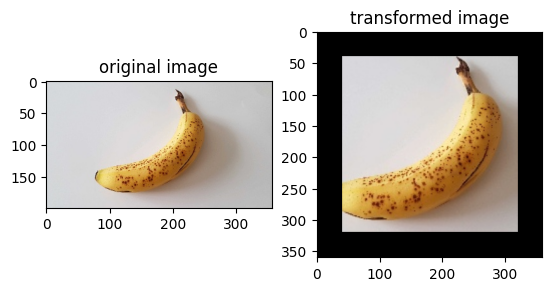

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import mindspore.dataset.vision as vision

img_ori = Image.open("banana.jpg").convert("RGB")
print("Image.type: {}, Image.shape: {}".format(type(img_ori), img_ori.size))

# Apply Resize to input immediately
op1 = vision.Resize(size=(320))
img = op1(img_ori)
print("Image.type: {}, Image.shape: {}".format(type(img), img.size))

# Apply CenterCrop to input immediately
op2 = vision.CenterCrop((280, 280))
img = op2(img)
print("Image.type: {}, Image.shape: {}".format(type(img), img.size))

# Apply Pad to input immediately
op3 = vision.Pad(40)
img = op3(img)
print("Image.type: {}, Image.shape: {}".format(type(img), img.size))

# Show the result
plt.subplot(1, 2, 1)
plt.imshow(img_ori)
plt.title("original image")
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title("transformed image")
plt.show()

#### text

此示例将使用`text`模块中Transforms，对给定文本进行变换。

Text Transforms的Eager模式支持`numpy.array`类型数据的作为入参。更多示例请参考：[样例库](https://www.mindspore.cn/docs/zh-CN/master/api_python/samples/dataset/text_gallery.html)

In [9]:
import mindspore.dataset.text.transforms as text
import mindspore as ms

# Apply UnicodeCharTokenizer to input immediately
txt = "Welcome to Beijing !"
txt = text.UnicodeCharTokenizer()(txt)
print("Tokenize result: {}".format(txt))

# Apply ToNumber to input immediately
txt = ["123456"]
to_number = text.ToNumber(ms.int32)
txt = to_number(txt)
print("ToNumber result: {}, type: {}".format(txt, txt[0].dtype))

Tokenize result: ['W' 'e' 'l' 'c' 'o' 'm' 'e' ' ' 't' 'o' ' ' 'B' 'e' 'i' 'j' 'i' 'n' 'g'
 ' ' '!']
ToNumber result: [123456], type: int32


#### audio

此示例将使用`audio`模块中Transforms，对给定音频进行变换。

Audio Transforms的Eager模式支持`numpy.array`类型数据的作为入参。更多示例请参考：[样例库](https://www.mindspore.cn/docs/zh-CN/master/api_python/samples/dataset/audio_gallery.html)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from download import download

import mindspore.dataset as ds
import mindspore.dataset.audio as audio

ds.config.set_seed(5)

# cication: LibriSpeech http://www.openslr.org/12
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/84-121123-0000.wav"
download(url, './84-121123-0000.wav', replace=True)
wav_file = "84-121123-0000.wav"

def plot_waveform(waveform, sr, title="Waveform"):
    if waveform.ndim == 1:
        waveform = waveform[np.newaxis, :]
    num_channels, num_frames = waveform.shape
    time_axis = np.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


file_sizes: 100%|███████████████████████████| 67.0k/67.0k [00:00<00:00, 756kB/s]
Successfully downloaded file to ./84-121123-0000.wav


BassBiquad 对输入的音频信号执行双极低搁架滤波器（two-pole low-shelf filter）。

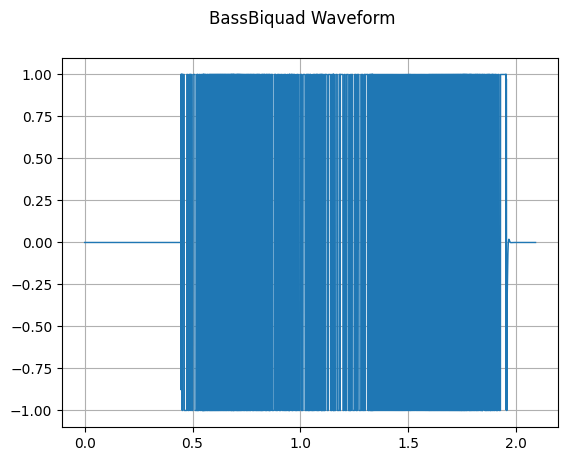

In [11]:
sample_rate, waveform = wavfile.read(wav_file)

bass_biquad = audio.BassBiquad(sample_rate, 10.0)
transformed_waveform = bass_biquad(waveform.astype(np.float32))
plot_waveform(transformed_waveform, sample_rate, title="BassBiquad Waveform")

#### transforms

此示例将使用`transforms`模块中通用Transform，对给定数据进行变换。

通用Transform的Eager模式支持`numpy.array`类型的数据作为入参。

In [12]:
import numpy as np
import mindspore.dataset.transforms as trans

# Apply Fill to input immediately
data = np.array([1, 2, 3, 4, 5])
fill = trans.Fill(0)
data = fill(data)
print("Fill result: ", data)

# Apply OneHot to input immediately
label = np.array(2)
onehot = trans.OneHot(num_classes=5)
label = onehot(label)
print("OneHot result: ", label)

Fill result:  [0 0 0 0 0]
OneHot result:  [0 0 1 0 0]
